In [1]:
import pudl
import pandas as pd
import numpy as np

# Making Sense of the Zillion EIA Aggregates

In [2]:
import sqlalchemy as sa
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])

In [3]:
aggs = pd.read_sql_table('fuel_receipts_costs_aggs_eia', pudl_engine)

## What Aggregates are there?
The aggregates break down over 4 dimensions (+ `report_date`):
* fuel type
* geography
* sector
* time scale

In [4]:
aggs.columns

Index(['fuel_agg', 'geo_agg', 'sector_agg', 'temporal_agg', 'report_date', 'fuel_received_mmbtu', 'fuel_cost_per_mmbtu'], dtype='object')

In [5]:
aggs.shape

(500537, 7)

In [6]:
dimensions = ['fuel_agg', 'geo_agg', 'sector_agg', 'temporal_agg']

### How Many?
There are over 6500 different groupings of aggregates. Each one is a time series, but most of them have few or zero values. Only 2286 have even a single value, and only 1181 (18%) have more than 50% coverage over time.

In [7]:
aggs.groupby(dimensions).ngroups

6517

In [8]:
aggs.query('fuel_cost_per_mmbtu.notnull()').groupby(dimensions).ngroups

2286

In [9]:
counts = aggs.groupby(dimensions)['fuel_cost_per_mmbtu'].agg(['size', 'count'])

array([[<AxesSubplot: title={'center': 'size'}>,
        <AxesSubplot: title={'center': 'count'}>]], dtype=object)

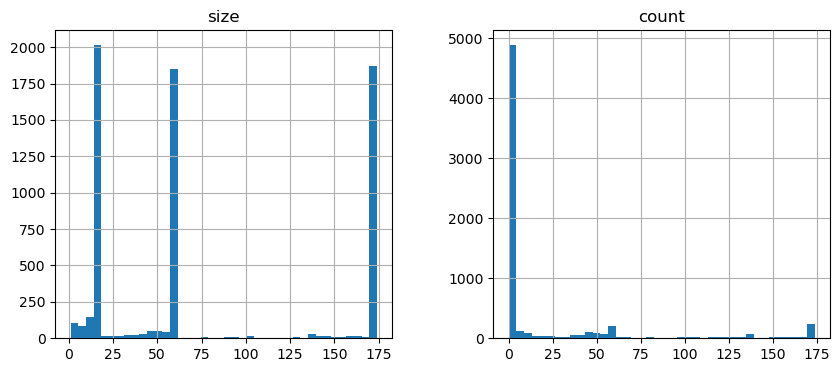

In [10]:
# peaks correspond to complete annual, quarterly, and monthly timeseries
counts.hist(bins=40, figsize=(10,4))

array([[<AxesSubplot: title={'center': 'size'}>,
        <AxesSubplot: title={'center': 'count'}>]], dtype=object)

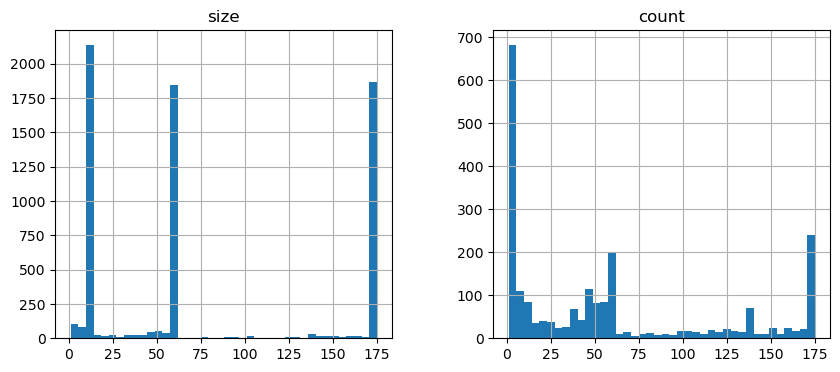

In [11]:
# remove completely empty aggregates
counts.hist(bins=40, figsize=(10,4), range=(1,175))

In [12]:
counts['count'].value_counts().nlargest(10)

0      4231
3       422
58      192
174     182
1       108
2        98
6        75
46       63
138      52
56       42
Name: count, dtype: int64

In [58]:
counts['coverage'] = counts['count'].groupby('temporal_agg').transform(lambda x: x.div(x.max()))

In [101]:
counts['coverage'].gt(0.5).agg(['sum', 'mean'])

sum     1181.000000
mean       0.181218
Name: coverage, dtype: float64

In [85]:
counts['coverage'].gt(0.5).groupby('temporal_agg').agg(['sum', 'mean'])

,sum,mean
temporal_agg,,
annual,74,0.032772
monthly,595,0.276359
quarterly,512,0.243115


## Data Coverage varies considerably by category

* Annual aggregates barely exist
* Generally weird stuff going on in 2011, 2012, and 2013
    * The cogen/non-cogen sectoral aggregates drop out of existence
    * coal coverage is reduced
    * national aggregates are reduced
    
The most stable period is 2014 to present.

array([[<AxesSubplot: title={'center': 'annual'}>,
        <AxesSubplot: title={'center': 'monthly'}>],
       [<AxesSubplot: title={'center': 'quarterly'}>, <AxesSubplot: >]],
      dtype=object)

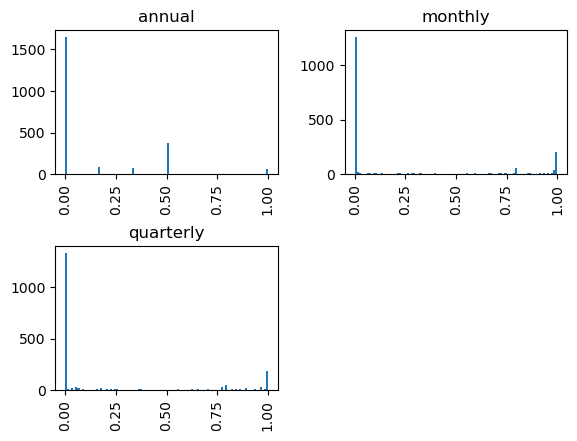

In [81]:
# Something is wrong with the annual aggregates. Why do most of them have exactly 50% coverage?
counts['coverage'].hist(bins=100, by='temporal_agg')

In [64]:
half_cov = counts.loc[np.isclose(counts['coverage'], 0.5, atol=0.001), :]

In [70]:
# 3 records is not 50% coverage!
half_cov.head(3)

size  count  coverage
fuel_agg geo_agg sector_agg       temporal_agg                       
all_coal AK      electric_utility annual          14      3       0.5
         AL      electric_utility annual          14      3       0.5
         AR      electric_utility annual          14      3       0.5

In [78]:
aggs.set_index(dimensions).loc[half_cov.index[0], :]

report_date  fuel_received_mmbtu  fuel_cost_per_mmbtu
fuel_agg geo_agg sector_agg       temporal_agg                                                      
all_coal AK      electric_utility annual        2008-01-01           3635334.39               1.4551
                                  annual        2009-01-01           3280786.95               1.2862
                                  annual        2010-01-01           4788373.03               1.4575
                                  annual        2011-01-01           4585196.27                  NaN
                                  annual        2012-01-01                 0.00                  NaN
                                  annual        2013-01-01                 0.00                  NaN
                                  annual        2014-01-01                 0.00                  NaN
                                  annual        2015-01-01           2400012.60                  NaN
                                  annual        2016-01-01           2787975.00                  NaN
                                  annual        2017-01-01           2448186.80                  NaN
                                  annual        2018-01-01           3707774.80                  NaN
                                  annual        2019-01-01           4702551.00                  NaN
                                  annual        2020-01-01           4952654.80                  NaN
                                  annual        2021-01-01           5145505.00                  NaN

<AxesSubplot: >

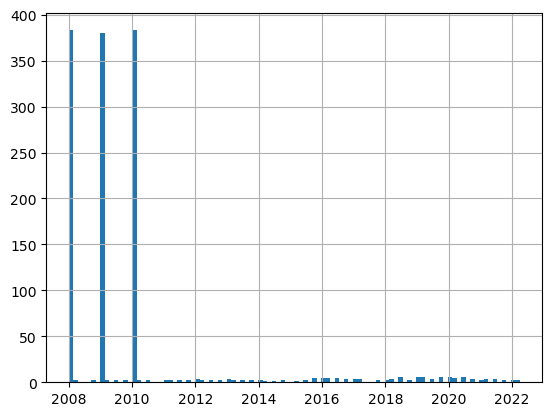

In [77]:
# the annual records are concentrated in the earliest data years. Quarterly are all over the place.
aggs.set_index(dimensions).dropna().loc[half_cov.index, 'report_date'].hist(bins=100)

In [80]:
# quarterly are just random records that happen to have 0.5 coverage
half_cov.loc[pd.IndexSlice[:,:,:,'quarterly'],:]

size  count  coverage
fuel_agg          geo_agg sector_agg         temporal_agg                       
natural_gas       UT      all_electric_power quarterly       58     29       0.5
petroleum_coke    MI      all_electric_power quarterly       58     29       0.5
petroleum_liquids NH      all_electric_power quarterly       58     29       0.5
                  PA      all_electric_power quarterly       58     29       0.5
                          all_ipp            quarterly       58     29       0.5
                  WV      all_electric_power quarterly       58     29       0.5

array([[<AxesSubplot: title={'center': 'annual'}>,
        <AxesSubplot: title={'center': 'monthly'}>],
       [<AxesSubplot: title={'center': 'quarterly'}>, <AxesSubplot: >]],
      dtype=object)

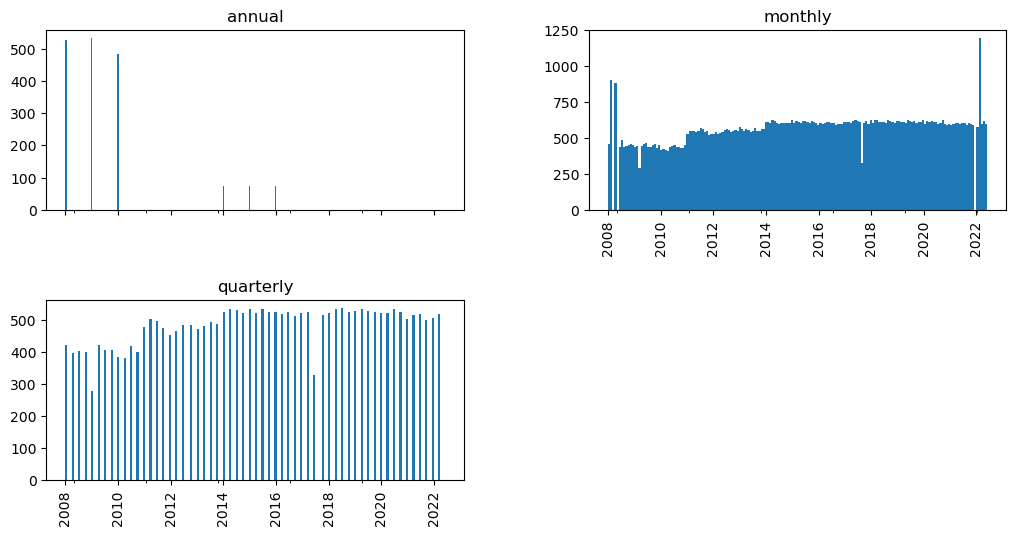

In [95]:
# annual aggregate prices are rarely available
aggs.dropna().set_index('temporal_agg').loc[:, 'report_date'].hist(bins=174, by='temporal_agg', figsize=(12,6), sharex=True)

array([[<AxesSubplot: title={'center': 'all_commercial'}>,
        <AxesSubplot: title={'center': 'all_electric_power'}>,
        <AxesSubplot: title={'center': 'all_industrial'}>],
       [<AxesSubplot: title={'center': 'all_ipp'}>,
        <AxesSubplot: title={'center': 'all_sectors'}>,
        <AxesSubplot: title={'center': 'commercial_cogen'}>],
       [<AxesSubplot: title={'center': 'commercial_non_cogen'}>,
        <AxesSubplot: title={'center': 'electric_utility'}>,
        <AxesSubplot: title={'center': 'industrial_cogen'}>],
       [<AxesSubplot: title={'center': 'industrial_non_cogen'}>,
        <AxesSubplot: title={'center': 'ipp_cogen'}>,
        <AxesSubplot: title={'center': 'ipp_non_cogen'}>]], dtype=object)

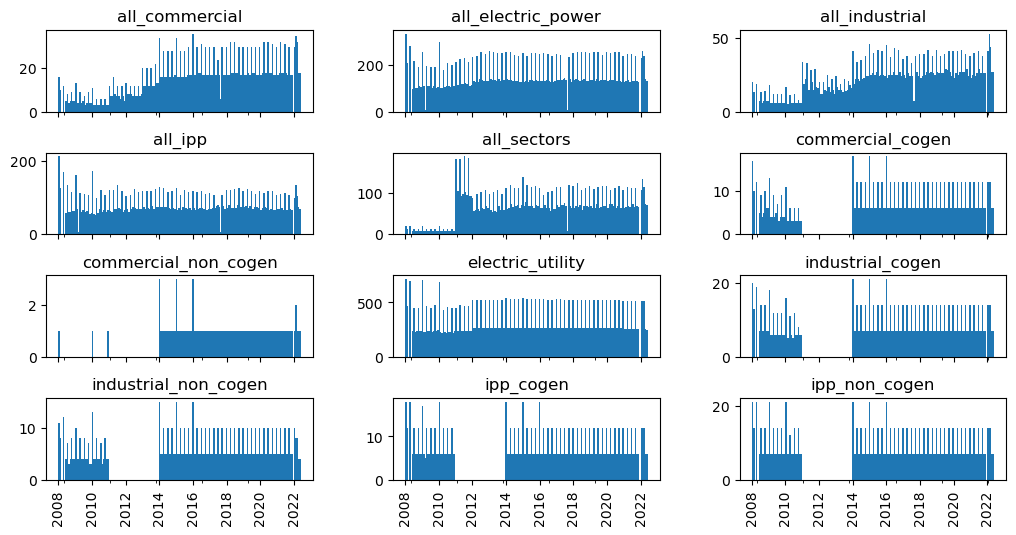

In [97]:
# check the other aggregate dimensions as well
aggs.dropna().set_index('sector_agg').loc[:, 'report_date'].hist(bins=174, by='sector_agg', figsize=(12,6), sharex=True)

array([[<AxesSubplot: title={'center': 'all_coal'}>,
        <AxesSubplot: title={'center': 'bituminous_coal'}>,
        <AxesSubplot: title={'center': 'lignite_coal'}>],
       [<AxesSubplot: title={'center': 'natural_gas'}>,
        <AxesSubplot: title={'center': 'petroleum_coke'}>,
        <AxesSubplot: title={'center': 'petroleum_liquids'}>],
       [<AxesSubplot: title={'center': 'sub_bituminous_coal'}>,
        <AxesSubplot: >, <AxesSubplot: >]], dtype=object)

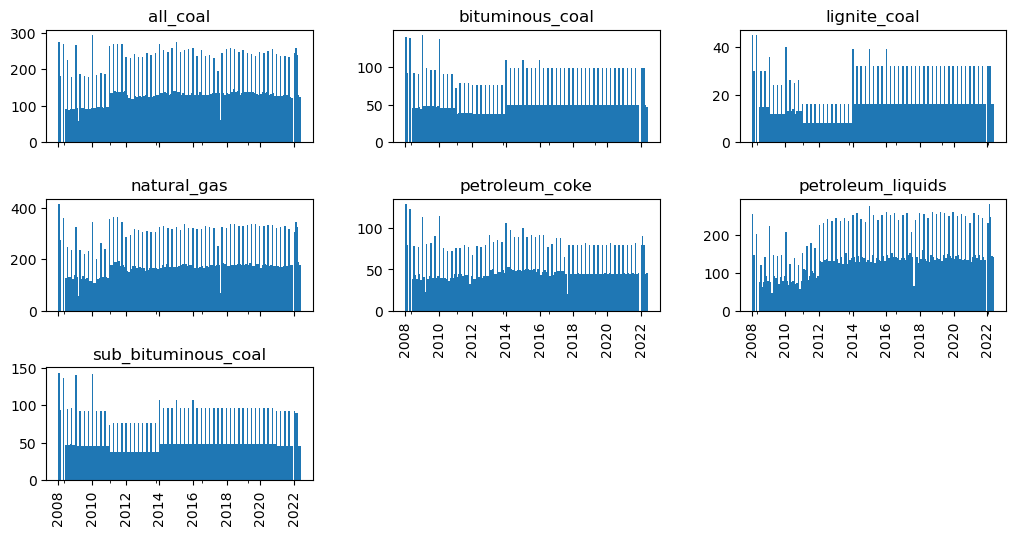

In [98]:
# check the other aggregate dimensions as well
aggs.dropna().set_index('fuel_agg').loc[:, 'report_date'].hist(bins=174, by='fuel_agg', figsize=(12,6), sharex=True)

In [99]:
aggs['geo_level'] = 'state'
aggs.loc[aggs['geo_agg'].eq('US'), 'geo_level'] = 'national'
aggs.loc[aggs['geo_agg'].str.len().eq(3), 'geo_level'] = 'regional'

array([[<AxesSubplot: title={'center': 'national'}>,
        <AxesSubplot: title={'center': 'regional'}>],
       [<AxesSubplot: title={'center': 'state'}>, <AxesSubplot: >]],
      dtype=object)

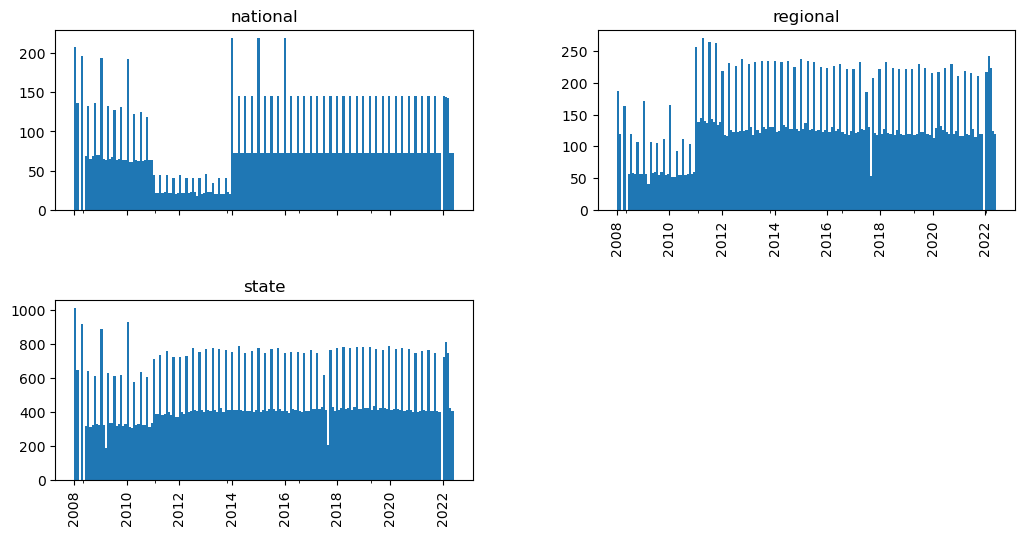

In [100]:
# check the other aggregate dimensions as well
aggs.dropna().set_index('geo_level').loc[:, 'report_date'].hist(bins=174, by='geo_level', figsize=(12,6), sharex=True)

In [102]:
aggs.drop(columns='geo_level', inplace=True)

### How Many Aggregates Does a Single FRC Record Contribute To?
Theoretically there can be up to 72 aggregates that contain a given fuel transaction:
* up to 4 sectoral levels (eg ipp_cogen, all_ipp, all_eletric_sector, all_sectors)
* up to 3 temporal levels (monthly, quarterly, annual)
* up to 2 fuel levels (eg BIT, all_coal)
* up to 3 geographic levels (state, census_region, national)

4\*3\*2\*3 = 72 

In practice that will generally be much lower due to poor data coverage. Discounting the rare annual aggregates drops the number to 48.

In [15]:
from pudl.metadata.dfs import (
    EIA_FUEL_AGGREGATE_ASSN,
    EIA_SECTOR_AGGREGATE_ASSN,
    POLITICAL_SUBDIVISIONS
)

In [16]:
EIA_FUEL_AGGREGATE_ASSN

,fuel_agg,energy_source_code_eia
0,bituminous_coal,BIT
1,sub_bituminous_coal,SUB
2,lignite_coal,LIG
3,all_coal,BIT
4,all_coal,SUB
5,all_coal,LIG
6,all_coal,WC
7,natural_gas,NG
8,petroleum_coke,PC
9,petroleum_liquids,DFO


In [17]:
EIA_FUEL_AGGREGATE_ASSN['energy_source_code_eia'].value_counts().max()

2

In [18]:
EIA_SECTOR_AGGREGATE_ASSN

,sector_agg,sector_id_eia
0,electric_utility,1
1,ipp_non_cogen,2
2,ipp_cogen,3
3,commercial_non_cogen,4
4,commercial_cogen,5
5,industrial_non_cogen,6
6,industrial_cogen,7
7,all_sectors,1
8,all_sectors,2
9,all_sectors,3


In [19]:
EIA_SECTOR_AGGREGATE_ASSN['sector_id_eia'].value_counts().max()

4

## Structuring for Imputation
I need to join aggregates to FRC index and convert to wide format so that each row is a single FRC fuel price with a vector of info needed for imputation. This will essentially add 72 additional columns to the FRC table - one for each possible aggregate. Many of those columns will be mostly NULL, but I'll deal with that later.

To do that I need to create associate tables between the aggregates and their components. It may also be useful to note the hierarchical structure of the aggregate categories.



### Sectoral Aggregate Associations

In [20]:
sectors = EIA_SECTOR_AGGREGATE_ASSN.sort_values('sector_id_eia')  # copy
map_sector_levels = { # some ambiguity about how to label electric_utility and all_electric_power
    "all_commercial": 2,
    "all_electric_power": 3,
    "all_industrial": 2,
    "all_ipp": 2,
    "all_sectors": 4,
    "commercial_cogen": 1,
    "commercial_non_cogen": 1,
    "electric_utility": 1,
    "industrial_cogen": 1,
    "industrial_non_cogen": 1,
    "ipp_cogen": 1,
    "ipp_non_cogen": 1,
}
sectors['sector_level'] = sectors['sector_agg'].map(map_sector_levels)
sectors = sectors.set_index('sector_id_eia').sort_index()
sectors

,sector_agg,sector_level
sector_id_eia,,
1,electric_utility,1
1,all_electric_power,3
1,all_sectors,4
2,ipp_non_cogen,1
2,all_ipp,2
2,all_electric_power,3
2,all_sectors,4
3,all_ipp,2
3,all_sectors,4


### Fuel Aggregate Associations

In [21]:
# NOTE: this fully represents the aggregates, but there are additional values of energy_source_code_eia 
# in the FRC data (niche gases like blast furnace gas). They simply don't have aggregates so will be all NULL.
fuels = EIA_FUEL_AGGREGATE_ASSN.sort_values('energy_source_code_eia')  # copy
map_fuel_levels = {
    "all_coal": 2,
    "bituminous_coal": 1,
    "lignite_coal": 1,
    "natural_gas": 1,
    "petroleum_coke": 1,
    "petroleum_liquids": 1,
    "sub_bituminous_coal": 1,
}
fuels['fuel_level'] = fuels['fuel_agg'].map(map_fuel_levels)
fuels = fuels.set_index('energy_source_code_eia').sort_index()
fuels

,fuel_agg,fuel_level
energy_source_code_eia,,
BIT,bituminous_coal,1
BIT,all_coal,2
DFO,petroleum_liquids,1
JF,petroleum_liquids,1
KER,petroleum_liquids,1
LIG,lignite_coal,1
LIG,all_coal,2
NG,natural_gas,1
PC,petroleum_coke,1


### Geographic Aggregate Associations

In [22]:
_filter = (  # states + DC
    POLITICAL_SUBDIVISIONS['country_code'].eq("USA")
    & POLITICAL_SUBDIVISIONS['subdivision_type'].isin({'state', 'district'})
    )
states_to_census = POLITICAL_SUBDIVISIONS.loc[_filter, ['subdivision_code', 'division_code_us_census']].rename(columns={
    'subdivision_code': 'state',
    'division_code_us_census': 'geo_agg',
}).reset_index(drop=True)  # copy
states_to_census['geo_level'] = 2
states_to_census

,state,geo_agg,geo_level
0,AK,PCN,2
1,AL,ESC,2
2,AR,WSC,2
3,AZ,MTN,2
4,CA,PCC,2
5,CO,MTN,2
6,CT,NEW,2
7,DC,SAT,2
8,DE,SAT,2
9,FL,SAT,2


In [23]:
states_to_states = pd.concat([
    states_to_census['state'],
    states_to_census['state'].rename('geo_agg'),
], axis=1)
states_to_states['geo_level'] = 1
states_to_states

,state,geo_agg,geo_level
0,AK,AK,1
1,AL,AL,1
2,AR,AR,1
3,AZ,AZ,1
4,CA,CA,1
5,CO,CO,1
6,CT,CT,1
7,DC,DC,1
8,DE,DE,1
9,FL,FL,1


In [24]:
states_to_national = states_to_states.loc[:, ['state']].copy()
states_to_national['geo_agg'] = 'US'
states_to_national['geo_level'] = 3
states_to_national

,state,geo_agg,geo_level
0,AK,US,3
1,AL,US,3
2,AR,US,3
3,AZ,US,3
4,CA,US,3
5,CO,US,3
6,CT,US,3
7,DC,US,3
8,DE,US,3
9,FL,US,3


In [25]:
geographies = pd.concat([
    states_to_census,
    states_to_states,
    states_to_national
], axis=0).set_index('state').sort_index()
geographies

,geo_agg,geo_level
state,,
AK,PCN,2
AK,AK,1
AK,US,3
AL,ESC,2
AL,AL,1
...,...,...
WV,WV,1
WV,SAT,2
WY,MTN,2


### Temporal Aggregate Associations

In [26]:
start_date = aggs['report_date'].min()
end_date = aggs['report_date'].max()
start_date, end_date

(Timestamp('2008-01-01 00:00:00'), Timestamp('2022-06-01 00:00:00'))

In [27]:
all_months = pd.date_range(start=start_date, end=end_date, inclusive='both', freq='MS')
all_months[:2], all_months[-2:]

(DatetimeIndex(['2008-01-01', '2008-02-01'], dtype='datetime64[ns]', freq='MS'),
 DatetimeIndex(['2022-05-01', '2022-06-01'], dtype='datetime64[ns]', freq='MS'))

In [28]:
all_quarters = pd.date_range(start=start_date, end=end_date, inclusive='both', freq='QS')
all_quarters[:2], all_quarters[-2:]

(DatetimeIndex(['2008-01-01', '2008-04-01'], dtype='datetime64[ns]', freq='QS-JAN'),
 DatetimeIndex(['2022-01-01', '2022-04-01'], dtype='datetime64[ns]', freq='QS-JAN'))

In [29]:
all_years = pd.date_range(start=start_date, end=end_date, inclusive='both', freq='AS')
all_years[:2], all_years[-2:]

(DatetimeIndex(['2008-01-01', '2009-01-01'], dtype='datetime64[ns]', freq='AS-JAN'),
 DatetimeIndex(['2021-01-01', '2022-01-01'], dtype='datetime64[ns]', freq='AS-JAN'))

In [30]:
month_to_annual = all_years.to_series().reindex(all_months, method='ffill').reset_index().rename(columns={'index': 'report_date', 0: 'report_date_agg'})
month_to_annual['temporal_level'] = 3
month_to_annual['temporal_agg'] = 'annual'
month_to_annual

,report_date,report_date_agg,temporal_level,temporal_agg
0,2008-01-01,2008-01-01,3,annual
1,2008-02-01,2008-01-01,3,annual
2,2008-03-01,2008-01-01,3,annual
3,2008-04-01,2008-01-01,3,annual
4,2008-05-01,2008-01-01,3,annual
...,...,...,...,...
169,2022-02-01,2022-01-01,3,annual
170,2022-03-01,2022-01-01,3,annual
171,2022-04-01,2022-01-01,3,annual
172,2022-05-01,2022-01-01,3,annual


In [31]:
month_to_quarter = all_quarters.to_series().reindex(all_months, method='ffill').reset_index().rename(columns={'index': 'report_date', 0: 'report_date_agg'})
month_to_quarter['temporal_level'] = 2
month_to_quarter['temporal_agg'] = 'quarterly'
month_to_quarter

,report_date,report_date_agg,temporal_level,temporal_agg
0,2008-01-01,2008-01-01,2,quarterly
1,2008-02-01,2008-01-01,2,quarterly
2,2008-03-01,2008-01-01,2,quarterly
3,2008-04-01,2008-04-01,2,quarterly
4,2008-05-01,2008-04-01,2,quarterly
...,...,...,...,...
169,2022-02-01,2022-01-01,2,quarterly
170,2022-03-01,2022-01-01,2,quarterly
171,2022-04-01,2022-04-01,2,quarterly
172,2022-05-01,2022-04-01,2,quarterly


In [32]:
month_to_month = all_months.to_series().reset_index().rename(columns={'index': 'report_date', 0: 'report_date_agg'})
month_to_month['temporal_level'] = 1
month_to_month['temporal_agg'] = 'monthly'
month_to_month

,report_date,report_date_agg,temporal_level,temporal_agg
0,2008-01-01,2008-01-01,1,monthly
1,2008-02-01,2008-02-01,1,monthly
2,2008-03-01,2008-03-01,1,monthly
3,2008-04-01,2008-04-01,1,monthly
4,2008-05-01,2008-05-01,1,monthly
...,...,...,...,...
169,2022-02-01,2022-02-01,1,monthly
170,2022-03-01,2022-03-01,1,monthly
171,2022-04-01,2022-04-01,1,monthly
172,2022-05-01,2022-05-01,1,monthly


In [33]:
temporal = pd.concat([
    month_to_annual,
    month_to_quarter,
    month_to_month,
], axis=0).set_index('report_date').sort_index()
temporal

,report_date_agg,temporal_level,temporal_agg
report_date,,,
2008-01-01,2008-01-01,3,annual
2008-01-01,2008-01-01,2,quarterly
2008-01-01,2008-01-01,1,monthly
2008-02-01,2008-01-01,3,annual
2008-02-01,2008-01-01,2,quarterly
...,...,...,...
2022-05-01,2022-01-01,3,annual
2022-05-01,2022-04-01,2,quarterly
2022-06-01,2022-04-01,2,quarterly


## Join Aggregate Labels onto FRC

In [34]:
associations = [temporal, geographies, sectors, fuels]

In [35]:
query = """
SELECT
    frc.plant_id_eia,
    frc.report_date,
    frc.energy_source_code as energy_source_code_eia,
    frc.fuel_received_units * frc.fuel_mmbtu_per_unit as fuel_mmbtu,
    frc.fuel_cost_per_mmbtu,

    entity.state,

    -- plants_eia860 is reported annually
    plants_860.sector_id_eia
FROM fuel_receipts_costs_eia923 as frc
LEFT JOIN plants_entity_eia as entity
    USING (plant_id_eia)
LEFT JOIN plants_eia860 as plants_860
    on frc.plant_id_eia = plants_860.plant_id_eia
        -- first day of report year
        AND date(strftime('%Y', frc.report_date) || '-01-01') = plants_860.report_date
;
"""
frc = pd.read_sql(query, pudl_engine).reset_index()  # reset_index to create a surrogate key

In [36]:
frc.shape

(608565, 8)

In [37]:
frc.sample(5)

,index,plant_id_eia,report_date,energy_source_code_eia,fuel_mmbtu,fuel_cost_per_mmbtu,state,sector_id_eia
503222,503222,10684,2019-02-01,BIT,1000810.674,NaN,CA,7.0
562906,562906,963,2020-10-01,NG,9888.000,6.512,IL,1.0
36474,36474,1361,2008-08-01,BIT,28591.332,3.033,KY,NaN
265617,265617,50776,2012-08-01,WC,166.870,NaN,PA,2.0
493247,493247,3935,2018-11-01,BIT,200633.826,2.594,WV,1.0


In [38]:
agg_keys = ['report_date', 'energy_source_code_eia', 'state', 'sector_id_eia']
frc.dropna(subset=agg_keys).shape

(535480, 8)

In [39]:
# sector id is biggest NaN source, but newer pudl version should fix that
frc[agg_keys].isna().value_counts()

report_date  energy_source_code_eia  state  sector_id_eia
False        False                   False  False            535480
                                            True              61919
                                     True   True              11165
             True                    False  False                 1
dtype: int64

In [40]:
frc_dropna = frc.dropna(subset=agg_keys).astype({'sector_id_eia': np.int8, 'report_date': np.datetime64})

In [41]:
joined = frc_dropna
for assoc in associations:
    joined = joined.merge(assoc, on=assoc.index.name, how='left')

In [42]:
joined.shape

(20868255, 17)

In [43]:
joined.shape[0] / frc_dropna.shape[0]  # should be somewhere between 1 and 72

38.97111936953761

In [44]:
joined.head(73).sort_values(dimensions)

,index,plant_id_eia,report_date,energy_source_code_eia,fuel_mmbtu,fuel_cost_per_mmbtu,state,sector_id_eia,report_date_agg,temporal_level,temporal_agg,geo_agg,geo_level,sector_agg,sector_level,fuel_agg,fuel_level
27,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,3,annual,AL,1,all_electric_power,3,all_coal,2.0
9,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,AL,1,all_electric_power,3,all_coal,2.0
63,61850,3,2009-01-01,BIT,4585924.0,3.503,AL,1,2009-01-01,1,monthly,AL,1,all_electric_power,3,all_coal,2.0
45,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,2,quarterly,AL,1,all_electric_power,3,all_coal,2.0
29,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,3,annual,AL,1,all_sectors,4,all_coal,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,2,quarterly,US,3,all_sectors,4,bituminous_coal,1.0
30,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,3,annual,US,3,electric_utility,1,bituminous_coal,1.0
12,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,US,3,electric_utility,1,bituminous_coal,1.0
66,61850,3,2009-01-01,BIT,4585924.0,3.503,AL,1,2009-01-01,1,monthly,US,3,electric_utility,1,bituminous_coal,1.0


## Join Aggregate Values

In [45]:
joined.memory_usage(deep=True) / 2**20

Index                      159.212151
index                      159.212151
plant_id_eia               159.212151
report_date                159.212151
energy_source_code_eia    1185.296737
fuel_mmbtu                 159.212151
fuel_cost_per_mmbtu        159.212151
state                     1174.189610
sector_id_eia               19.901519
report_date_agg            159.212151
temporal_level             159.212151
temporal_agg              1280.331044
geo_agg                   1180.823450
geo_level                  159.212151
sector_agg                1413.615672
sector_level               159.212151
fuel_agg                  1371.029995
fuel_level                 159.212151
dtype: float64

In [46]:
joined.memory_usage(deep=True).sum() / 2**20

9376.521683692932

In [47]:
joined = joined.merge(aggs.rename(columns={
    'report_date': 'report_date_agg',
    'fuel_cost_per_mmbtu': 'fuel_cost_per_mmbtu_agg',
    'fuel_received_mmbtu': 'fuel_received_mmbtu_agg'
}),
                      on=dimensions + ['report_date_agg'],
                      how='left',
                      copy=False
                     )

In [48]:
joined.shape

(20868255, 19)

In [49]:
joined.head(5)

,index,plant_id_eia,report_date,energy_source_code_eia,fuel_mmbtu,fuel_cost_per_mmbtu,state,sector_id_eia,report_date_agg,temporal_level,temporal_agg,geo_agg,geo_level,sector_agg,sector_level,fuel_agg,fuel_level,fuel_received_mmbtu_agg,fuel_cost_per_mmbtu_agg
0,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,ESC,2,electric_utility,1,bituminous_coal,1.0,1.428104e+08,2.800101
1,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,ESC,2,electric_utility,1,all_coal,2.0,1.834725e+08,2.672003
2,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,ESC,2,all_electric_power,3,bituminous_coal,1.0,1.430304e+08,NaN
3,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,ESC,2,all_electric_power,3,all_coal,2.0,1.870139e+08,NaN
4,61849,3,2009-01-01,BIT,2889432.0,6.311,AL,1,2009-01-01,1,monthly,ESC,2,all_sectors,4,bituminous_coal,1.0,1.482811e+08,NaN


In [50]:
joined.drop(columns=dimensions + ['report_date_agg'], inplace=True)

In [51]:
cardinalities = joined.nunique()
cardinalities

index                      535480
plant_id_eia                 1683
report_date                   156
energy_source_code_eia         15
fuel_mmbtu                 468235
fuel_cost_per_mmbtu         24966
state                          51
sector_id_eia                   7
temporal_level                  3
geo_level                       3
sector_level                    4
fuel_level                      2
fuel_received_mmbtu_agg    170137
fuel_cost_per_mmbtu_agg     52108
dtype: int64

In [52]:
low_cardinality_cols = cardinalities.loc[cardinalities.lt(100)].index

In [53]:
joined.loc[:, low_cardinality_cols] = joined.loc[:, low_cardinality_cols].astype('category', copy=False)

/tmp/ipykernel_29859/450644761.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  joined.loc[:, low_cardinality_cols] = joined.loc[:, low_cardinality_cols].astype('category', copy=False)


In [54]:
joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20868255 entries, 0 to 20868254
Data columns (total 14 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   index                    int64         
 1   plant_id_eia             int64         
 2   report_date              datetime64[ns]
 3   energy_source_code_eia   category      
 4   fuel_mmbtu               float64       
 5   fuel_cost_per_mmbtu      float64       
 6   state                    category      
 7   sector_id_eia            category      
 8   temporal_level           category      
 9   geo_level                category      
 10  sector_level             category      
 11  fuel_level               category      
 12  fuel_received_mmbtu_agg  float64       
 13  fuel_cost_per_mmbtu_agg  float64       
dtypes: category(7), datetime64[ns](1), float64(4), int64(2)
memory usage: 1.4 GB


## Reshape to Matrix Form

In [55]:
test = (
    joined.sample(1000)
    .set_index(['index'] + [col for col in joined.columns if col.endswith('_level')])
    ['fuel_cost_per_mmbtu_agg']
    .unstack(level=[1,2,3,4])
    .sort_index(axis=1)
)
test

temporal_level   1                                                                                                             2                                                                                               3                                                                                                                  
geo_level        1                               2                                   3                                         1                               2                               3                               1                                           2                                     3                                
sector_level     1       2       3       4       1       2       3           4       1       2       3           4             1       2       3       4       1       2       3       4       1       2       3       4       1           2           3           4       1       2       3             4       1       2           3       4    
fuel_level     1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 nan 1.0 2.0 1.0 2.0 1.0 2.0 1.0     2.0 1.0 2.0       1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 1.0 2.0 nan 1.0 2.0 nan 1.0 2.0 nan 1.0 2.0 1.0 2.0 1.0 2.0 1.0       2.0 1.0 2.0 1.0 2.0 1.0 2.0     1.0 2.0 1.0 2.0
index                                                                                                                                                                                                                                                                                                                                             
61900          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.2073 NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN NaN
61914          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN  2.7406 NaN NaN NaN
62486          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN NaN
63054          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN  4.806271 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN NaN
63226          NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  2.395771 NaN NaN NaN NaN NaN NaN     NaN NaN NaN NaN
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..     ...  ..  ..       ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..       ...  ..  ..  ..  ..  ..  ..     ...  ..  ..  ..
607397         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN     NaN NaN NaN       NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN Na

More than 72 columns because of NaN fuel_levels due to other gas types that don't appear in EIA aggregates.

In [56]:
test.isna().sum().sum() / test.size  # 99.3% sparse sounds too high. Maybe my joins keep too many rows

0.9936447368421053

## Next Steps
1. Null handling.
    1. When sector or state are null, can still use all_sectors or national aggregates. Can probably do even better on sector based on correlation with redacted prices.
    1. When fuel_agg is null (other gases) I should drop the row from the join rather than add a NaN fuel_level
1. reshape to wide format (restore original rows)
1. merge dev and make PR
1. make module
1. optional: make join more efficient by pruning null aggregates beforehand